In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, TimeDistributed, Dropout, RepeatVector, Concatenate
from tensorflow.keras.models import load_model
from keras.models import Sequential
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/ara_eng.txt", delimiter="\t", names=["english", "arabic"])
data.head()

,english,arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [4]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,english,arabic
0,other medical personnel at the institution are...,كما بدا العديد من الاشخاص بالمستشفى باستخدام ت...
1,with the cost of newsprint rising rapidly and ...,مع ارتفاع تكلفة طباعة الصحف المتزايد وندرة وجو...
2,I'm so proud of you.,أنا فخور جداً بكَ.
3,earlier this month students at zanjan universi...,في بداية الشهر الحالي قام طلاب من جامعة زنجان ...
4,the committee to protect bloggers is back glob...,لجنة حماية المدونين تعود الاصوات العالمية


In [5]:
def preprocess_arabic_text(text):
    text = re.sub("[\u064B-\u0652]", "", text)  # Remove diacritics
    text = re.sub("[^؀-ۿ]", " ", text)          # Remove non-Arabic characters
    return text

In [6]:
def preprocess_english_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub("[^a-zA-Z\s]", "", text)
    return text

In [7]:
data = data[data['english'].apply(lambda x: len(word_tokenize(x))) <= 10].reset_index(drop=True)

In [8]:
data['arabic'] = data['arabic'].apply(preprocess_arabic_text)
data['english'] = data['english'].apply(preprocess_english_text)
data.head()

,english,arabic
0,im so proud of you,أنا فخور جدا بك
1,the committee to protect bloggers is back glob...,لجنة حماية المدونين تعود الاصوات العالمية
2,i wanted to go there,أردت الذهاب إلى هناك
3,maryam is well behaved,مريم ذات خلق
4,what are you doing,ما الذي تفعله؟


In [9]:
english = data['english']
arabic = data['arabic']

In [10]:
arabic[200]

'موقع الاصوات العالمية يعاد تصميمه مرحبا بكم مجددا الاصوات العالمية'

In [11]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [12]:
def pad(x, max_length):
    return pad_sequences(x, maxlen=max_length, padding='post')

In [13]:
def preprocess(x, y, max_length):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x, max_length)
    preprocess_y = pad(preprocess_y, max_length)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [14]:
max_sequence_length = 10
preproc_english, preproc_arabic, english_tokenizer, arabic_tokenizer = preprocess(english, arabic, max_sequence_length)

In [15]:
preproc_english[1500]

array([  2,  33,  14,  21,  58, 571,   0,   0,   0,   0], dtype=int32)

In [16]:
max_english_sequence_length = preproc_english.shape[1]
max_arabic_sequence_length = preproc_arabic.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
arabic_vocab_size = len(arabic_tokenizer.word_index)
print("Max English sentence length:", max_english_sequence_length)
print("Max arabic sentence length:", max_arabic_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("Arabic vocabulary size:", arabic_vocab_size)

Max English sentence length: 10
Max arabic sentence length: 10
English vocabulary size: 7458
Arabic vocabulary size: 15661


In [17]:
def to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '0'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [18]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, arabic_vocab_size):

    learning_rate = 0.002

    # Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(arabic_vocab_size, activation='softmax')))

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [19]:
# Reshape the input
tmp_x = preproc_english.reshape((-1, preproc_arabic.shape[-2]))

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model = bd_model(
    tmp_x.shape,
    preproc_arabic.shape[1],
    len(english_tokenizer.word_index) + 1,
    len(arabic_tokenizer.word_index) + 1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 256)           1909504   
                                                                 
 bidirectional (Bidirection  (None, 10, 512)           789504    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 10, 1024)          525312    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 10, 1024)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 15662)         16053550  
 stributed)                                                      
                                                        

In [21]:
tmp_x.shape

(13414, 10)

In [32]:
# Load the model
loaded_model = load_model("/content/drive/MyDrive/eng2arb_name.h5")

In [22]:
history = model.fit(
    tmp_x, preproc_arabic,
    batch_size=64,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopping])

Epoch 1/50
189/189 [==============================] - 22s 70ms/step - loss: 4.0727 - accuracy: 0.5581 - val_loss: 3.6998 - val_accuracy: 0.5753
Epoch 2/50
189/189 [==============================] - 8s 45ms/step - loss: 3.4266 - accuracy: 0.5939 - val_loss: 3.4904 - val_accuracy: 0.5998
Epoch 3/50
189/189 [==============================] - 8s 44ms/step - loss: 3.0710 - accuracy: 0.6120 - val_loss: 3.3604 - val_accuracy: 0.6142
Epoch 4/50
189/189 [==============================] - 9s 45ms/step - loss: 2.7518 - accuracy: 0.6277 - val_loss: 3.3436 - val_accuracy: 0.6228
Epoch 5/50
189/189 [==============================] - 9s 45ms/step - loss: 2.4332 - accuracy: 0.6437 - val_loss: 3.3118 - val_accuracy: 0.6279
Epoch 6/50
189/189 [==============================] - 9s 46ms/step - loss: 2.1100 - accuracy: 0.6612 - val_loss: 3.2856 - val_accuracy: 0.6351
Epoch 7/50
189/189 [==============================] - 8s 44ms/step - loss: 1.7801 - accuracy: 0.6816 - val_loss: 3.3084 - val_accuracy: 0.635

In [31]:
model.save("/content/drive/MyDrive/eng2arb_name.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


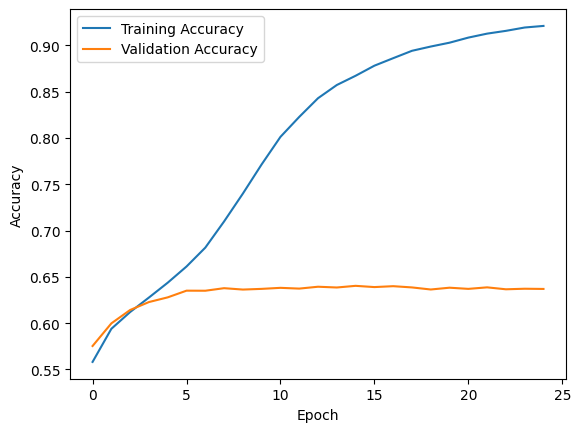

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

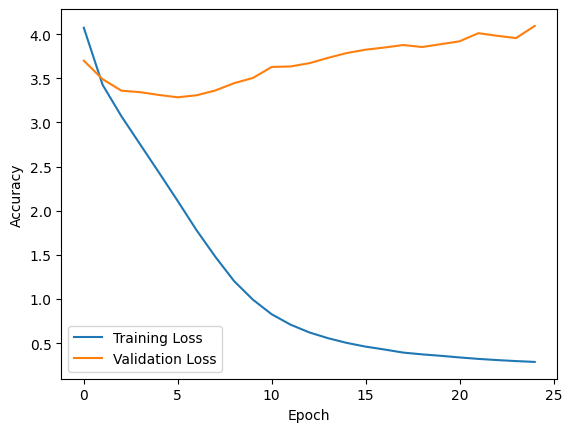

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [28]:
i=5

print("Prediction:")
print(to_text(model.predict(tmp_x[[i]])[0],arabic_tokenizer))

print("\nCorrect Translation:")
print(arabic[i])

print("\nOriginal text:")
print(english[i])

Prediction:
1/1 [==============================] - 0s 58ms/step
هو اغضبني حقا 0 0 0 0 0 0 0

Correct Translation:
هو اغضبني حقا  

Original text:
he really ticked me off


In [29]:
# Function to preprocess user input and perform translation
def translate_sentence(input_sentence, english_tokenizer, arabic_tokenizer, model, max_english_sequence_length):
    # Preprocess the user input
    preprocessed_input = preprocess_english_text(input_sentence)
    # Tokenize and pad the preprocessed user input
    input_sequence = english_tokenizer.texts_to_sequences([preprocessed_input])
    input_sequence = pad_sequences(input_sequence, maxlen=max_english_sequence_length, padding='post')

    # Get the model's prediction
    predicted = model.predict(input_sequence)
    # Convert model output to text
    translated_sentence = to_text(predicted[0], arabic_tokenizer)

    return translated_sentence

# Example usage:
user_input = input("Enter an English sentence: ")

# Call the translation function
translation = translate_sentence(user_input, english_tokenizer, arabic_tokenizer, model, max_english_sequence_length)
print("Translated Arabic sentence:", translation)

Enter an English sentence: i went to school
1/1 [==============================] - 0s 18ms/step
Translated Arabic sentence: ذهبت إلى المدرسة 0 0 0 0 0 0 0


In [30]:
# Function to preprocess user input and perform translation
def translate_sentence(input_sentence, english_tokenizer, arabic_tokenizer, model, max_english_sequence_length):
    # Preprocess the user input
    preprocessed_input = preprocess_english_text(input_sentence)
    # Tokenize and pad the preprocessed user input
    input_sequence = english_tokenizer.texts_to_sequences([preprocessed_input])
    input_sequence = pad_sequences(input_sequence, maxlen=max_english_sequence_length, padding='post')

    # Get the model's prediction
    predicted = model.predict(input_sequence)
    # Convert model output to text
    translated_sentence = to_text(predicted[0], arabic_tokenizer)

    return translated_sentence

# Example usage:
user_input = input("Enter an English sentence: ")

# Call the translation function
translation = translate_sentence(user_input, english_tokenizer, arabic_tokenizer, model, max_english_sequence_length)
print("Translated Arabic sentence:", translation)

Enter an English sentence: i will go to school
1/1 [==============================] - 0s 19ms/step
Translated Arabic sentence: سأذهب إلى المدرسة 0 0 0 0 0 0 0
